<a href="https://colab.research.google.com/github/santolina/pytorch_handbook/blob/master/PytorchHandbook_chap4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-01-01 05:15:27--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.2.123, 13.224.2.111, 13.224.2.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.2.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  41.6MB/s    in 1.1s    

2020-01-01 05:15:33 (41.6 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [2]:
ls

hymenoptera_data/  hymenoptera_data.zip  sample_data/


In [0]:
import cv2
img = cv2.imread('./hymenoptera_data/val/bees/abeja.jpg')

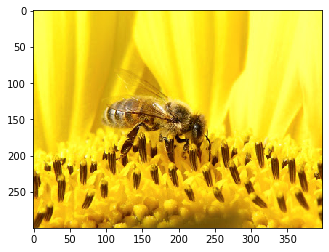

In [4]:
import matplotlib.pyplot as plt 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

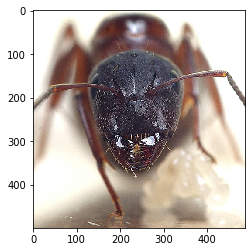

In [5]:
from PIL import Image
image = './hymenoptera_data/train/ants/382971067_0bfd33afe0.jpg'
with open(image, 'rb') as f:
  image = Image.open(f)
  image = image.convert('RGB')

plt.imshow(image)
plt.show()

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
# define preprosessing for image
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])                               
    ])
}

# preprosessing w/o normalization
to_tensor_transforms = transforms.Compose([
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor()
])

In [0]:
#define custom dataset
root = 'hymenoptera_data'
class CustomDataset(torch.utils.data.Dataset):
  classes = ['ant', 'bees']

  def __init__(self, root, transform=None, train=True):
    # sepecify transform if necessary
    self.transform = transform 

    self.images = list()
    self.labels = list()

    self.root = root

    if train == True:
      root_ants_path = os.path.join(self.root, 'train', 'ants')
      root_bees_path = os.path.join(self.root, 'train', 'bees')
    else:
      root_ants_path = os.path.join(self.root, 'val', 'ants')
      root_bees_path = os.path.join(self.root, 'val', 'bees')

    # get ants images' list
    ant_images = os.listdir(root_ants_path)
    ant_labels = [0]*len(ant_images)

    bee_images = os.listdir(root_bees_path)
    bee_labels = [1]*len(bee_images)

    # combine
    for image, label in zip(ant_images, ant_labels):
      self.images.append(os.path.join(root_ants_path, image))
      self.labels.append(label)

    for image, label in zip(bee_images, bee_labels):
      self.images.append(os.path.join(root_bees_path, image))
      self.labels.append(label)
     ################################
  
  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    with open(image, 'rb') as f:
      image = Image.open(f)
      image = image.convert('RGB')
    
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

  def __len__(self):
    return len(self.images)

  

[0 0 1 1 1]


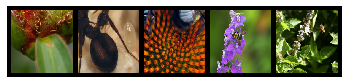

In [9]:
# load dataset
custom_dataset = CustomDataset(root, to_tensor_transforms, train=True)

custom_loader = torch.utils.data.DataLoader(dataset = custom_dataset, batch_size=5, shuffle=True)

def show(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
  print(labels.numpy())
  show(torchvision.utils.make_grid(images, padding=16))
  plt.axis('off')
  break

In [11]:
size_check = torch.FloatTensor(10, 3, 224, 224)
features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2)                                   
    
)

print(features(size_check).view(size_check.size(0), -1).size())

fc_size = features(size_check).view(size_check.size(0), -1).size()[1]
print(fc_size)

torch.Size([10, 9216])
9216


In [12]:
#define network

num_classes = 2

class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 192, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2)                                   
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(fc_size, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
  
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AlexNet().to(device) #<--- 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [0]:
# training
def train(net, criterion, optimizer, train_loader, test_loader, device, num_epoch=50):

  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []

  for epoch in range(num_epoch):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # train=====
    # change training mode
    net.train()

    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      
      # reset  gradient
      optimizer.zero_grad()

      # forward propagation
      outputs = net(images)

      # calc loss
      loss = criterion(outputs, labels)

      train_loss += loss.item()

      train_acc += (outputs.max(1)[1] == labels).sum().item()

      # back propagation
      loss.backward()

      # update weight
      optimizer.step()

    # average loss and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # val====
    # change evaluation mode
    net.eval()

    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_acc += (outputs.max(1)[1]==labels).sum().item()
    
      avg_val_loss = val_loss / len(test_loader.dataset)
      avg_val_acc = val_acc / len(test_loader.dataset)

    # output loss and acc of training and test

    print('Epoc [{}/{}], loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'.format(
      epoch+1, num_epoch, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # store data to plot graph
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

  return train_loss_list, train_acc_list, val_loss_list, val_acc_list, net,

In [17]:
train_dataset = CustomDataset(root, to_tensor_transforms, train=True)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=5, shuffle=True)

test_dataset = CustomDataset(root, to_tensor_transforms, train=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=5, shuffle=False)

train_loss_list, train_acc_list, val_loss_list, val_acc_list, net = train(net, criterion, optimizer, train_loader, test_loader, device, num_epoch=50)

Epoc [1/50], loss: 0.1419, val_loss: 0.1412, val_acc: 0.4641
Epoc [2/50], loss: 0.1402, val_loss: 0.1400, val_acc: 0.5425
Epoc [3/50], loss: 0.1401, val_loss: 0.1408, val_acc: 0.5425
Epoc [4/50], loss: 0.1411, val_loss: 0.1517, val_acc: 0.4575
Epoc [5/50], loss: 0.1401, val_loss: 0.1466, val_acc: 0.4575
Epoc [6/50], loss: 0.1402, val_loss: 0.1515, val_acc: 0.4575
Epoc [7/50], loss: 0.1430, val_loss: 0.1492, val_acc: 0.4575
Epoc [8/50], loss: 0.1450, val_loss: 0.1522, val_acc: 0.4575
Epoc [9/50], loss: 0.1420, val_loss: 0.1409, val_acc: 0.5425
Epoc [10/50], loss: 0.1411, val_loss: 0.1415, val_acc: 0.4575
Epoc [11/50], loss: 0.1409, val_loss: 0.1403, val_acc: 0.5425
Epoc [12/50], loss: 0.1408, val_loss: 0.1399, val_acc: 0.5425
Epoc [13/50], loss: 0.1416, val_loss: 0.1407, val_acc: 0.5425
Epoc [14/50], loss: 0.1373, val_loss: 0.1652, val_acc: 0.5425
Epoc [15/50], loss: 0.1418, val_loss: 0.1401, val_acc: 0.5425
Epoc [16/50], loss: 0.1410, val_loss: 0.1467, val_acc: 0.4575
Epoc [17/50], los

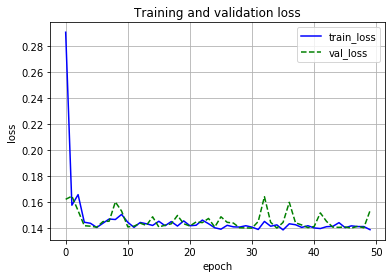

In [15]:
num_epoch=50
plt.figure()

plt.plot(range(num_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.show()


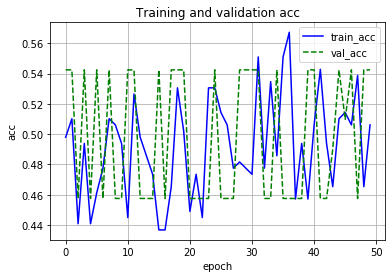

In [16]:
num_epoch=50
plt.figure()

plt.plot(range(num_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.grid()
plt.show()

# dataloader using ImageFolder

In [0]:
data_dir = './hymenoptera_data'

train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=5, shuffle=False, num_workers=4)

In [22]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list, net = train(net, criterion, optimizer, train_loader, test_loader, device, num_epoch=100)

Epoc [1/200], loss: 0.1416, val_loss: 0.1349, val_acc: 0.6013
Epoc [2/200], loss: 0.1332, val_loss: 0.1319, val_acc: 0.6144
Epoc [3/200], loss: 0.1317, val_loss: 0.1369, val_acc: 0.5882
Epoc [4/200], loss: 0.1434, val_loss: 0.1531, val_acc: 0.4575
Epoc [5/200], loss: 0.1416, val_loss: 0.1362, val_acc: 0.6078
Epoc [6/200], loss: 0.1339, val_loss: 0.1304, val_acc: 0.6340
Epoc [7/200], loss: 0.1374, val_loss: 0.1794, val_acc: 0.5490
Epoc [8/200], loss: 0.1426, val_loss: 0.1406, val_acc: 0.4771
Epoc [9/200], loss: 0.1334, val_loss: 0.1351, val_acc: 0.5817
Epoc [10/200], loss: 0.1334, val_loss: 0.1333, val_acc: 0.6078
Epoc [11/200], loss: 0.1364, val_loss: 0.1443, val_acc: 0.5490
Epoc [12/200], loss: 0.1341, val_loss: 0.1443, val_acc: 0.6144
Epoc [13/200], loss: 0.1317, val_loss: 0.1323, val_acc: 0.6144
Epoc [14/200], loss: 0.1346, val_loss: 0.1393, val_acc: 0.5621
Epoc [15/200], loss: 0.1378, val_loss: 0.1350, val_acc: 0.5556
Epoc [16/200], loss: 0.1357, val_loss: 0.1335, val_acc: 0.6144
E